# Smart data sampling

In [2]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from common.dataset import FilesFromCsvDataset, TrainvalFilesDataset, TransformedDataset, read_image, TestFilesDataset

In [3]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

from common.sampling import SmartWeightedRandomSampler

In [58]:
def get_targets_distribution(dataset, sampler):
    targets = np.zeros((len(sampler), ), dtype=np.int)
    for i, index in enumerate(sampler):
        _, y = dataset[index]
        targets[i] = y    
    return np.bincount(targets)

In [60]:
dataset = FilesFromCsvDataset("../output/filtered_train_dataset.csv")

targets = np.zeros((len(dataset), ), dtype=np.int)
for i, dp in enumerate(dataset):
    targets[i] = dp[1]
    
sampler = SmartWeightedRandomSampler(targets)

targets_distribution = get_targets_distribution(dataset, sampler)
targets_distribution[1:11]

array([1307, 1507, 2333, 1433, 1556, 1068, 1528, 1347,  454, 1991])

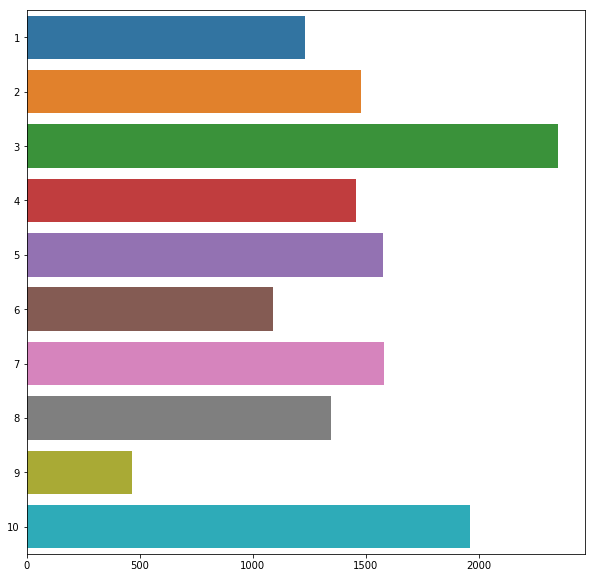

In [7]:
plt.figure(figsize=(10, 10))
sns.barplot(x=targets_distribution[1:11], y=np.arange(1, 11), orient='h')

In [61]:
class_weights = [
    (9, 5.0)
]

In [62]:
sampler.update_weights(class_weights)

In [63]:
len(sampler.weights_indices_per_class[9])

465

In [64]:
(sampler.weights > 1).sum()

465

In [65]:
# sampler.num_samples = len(targets) - 1000

In [67]:
new_targets_distribution = get_targets_distribution(dataset, sampler)
targets_distribution[1:11], new_targets_distribution[1:11]

(array([1307, 1507, 2333, 1433, 1556, 1068, 1528, 1347,  454, 1991]),
 array([1308, 1413, 2422, 1441, 1551, 1120, 1618, 1300, 2357, 1909]))

Small examples to debug

In [ ]:
y = np.array(list([0] * 100 + [1] * 50 + [2] * 30))
dataset = np.concatenate([y[:, None], y[:, None]], axis=1)

weights = np.ones(len(y))

In [52]:
from torch.utils.data.sampler import WeightedRandomSampler


sampler = WeightedRandomSampler(weights, num_samples=len(y), replacement=True)

In [53]:
indices = np.where(y == 2)[0].tolist()
sampler.weights[indices] = 5.0

indices = list(iter(sampler))

In [54]:
np.bincount(y[indices])

array([50, 33, 97])

In [57]:
get_targets_distribution(dataset, sampler)

array([67, 30, 83])

In [70]:
import torch

weights = np.zeros(30)
weights[1] = 0.0

np.bincount(torch.multinomial(torch.Tensor(weights), 30, replacement=True).numpy())

RuntimeError: invalid argument 2: invalid multinomial distribution (sum of probabilities <= 0) at /pytorch/torch/lib/TH/generic/THTensorRandom.c:291